In [1]:
import PAA_LISA
import NOISE_LISA
import os

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from fractions import Fraction
import math
import datetime
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')
#warnings.filterwarnings("error")
import scipy.optimize

year2sec=32536000
day2sec=year2sec/365.25
c=300000000

In [2]:
input_param = {
        'calc_method': 'Waluschka',
        'plot_on':False, #If plots will be made
        'dir_savefig': os.getcwd(), # The directory where the figures will be saved. If False, it will be in the current working directory
        'noise_check':False,
        'home':'/home/ester/git/synthlisa/', # Home directory
        'directory_imp': False,
        'num_back': 0,
        'dir_orbits': '/home/ester/git/synthlisa/orbits/', # Folder with orbit files
        'length_calc': 20, # Length of number of imported datapoints of orbit files. 'all' is also possible
        'dir_extr': 'zzzWaluschka_no_abberation', # This will be added to the folder name of the figures
        'timeunit':'Default', # The timeunit of the plots (['minutes'],['days']['years'])
        'LISA_opt':True, # If a LISA object from syntheticLISA will be used for further calculations (not sure if it works properly if this False)
        'arm_influence': True, # Set True to consider the travel time of the photons when calculating the nominal armlengths
        'tstep':False,
        'delay':True, #'Not ahead' or False
        'method':'fsolve', # Method used to solve the equation for the photon traveling time
        'valorfunc':'Function', #
        'select':'Hallion', # Select which orbit files will be imported ('all' is all)
        'test_calc':False,
        'abberation':False,
        'delay': True
        }

data_all = PAA_LISA.runfile.do_run(input_param)

['positions_timestep_days_scale_1000.txt', 'Folkner_orbit_timestep_seconds_scale_10.txt', 'readable.py', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1000.txt']
['McKenzie_orbit_timestep_seconds_scale_1000.txt', 'Folkner_orbit_timestep_seconds_scale_1.txt', 'Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000.txt']
['Folkner_orbit_timestep_seconds_scale_10.txt', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1.txt', 'Folkner_orbit_timestep_seconds_scale_1.txt', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1000.txt']
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Getting scale by filename:
1000.0

Getting timestep by filename:
days

Waluschka

Importing Orbit
20 datapoints
Done in 0.030418
Selected calculation method is: Waluschka

Selected calculation method is: Waluschka

Selected calculation method is: Waluschka



In [3]:
for k in range(0,len(data_all)/2):
    #data = PAA_res[str(k+1)]
    data = data_all[str(k+1)]
t_vec = data.t_all

In [4]:
Ndata = NOISE_LISA.Noise(data=data)

Obtaining noise
Obaining lasernoise
Obtaining shotnoise


In [5]:
Ndata.PAA_point

<bound method Noise.PAA_point of <NOISE_LISA.calc.Noise instance at 0x7fa26434c200>>

In [6]:
wfe = NOISE_LISA.WFE(Ndata=Ndata)

In [7]:
wfe.tele_control='full control'
wfe.pupil(Nbins=20)
wfe.side = 'r'
wfe.scale = 1#1e-9 # Scales distance of SC

wfe.speed_on = True # Makes calculation faster, only valid for long armlengths
wfe.simple = True # Calculates only 1 pixel

In [8]:
wfe.tele_control_ss(step_max=4,dt = 3600)

0

In [9]:
i=1
t = t_vec[2]
wfe.simple=False
wfe.jitter=[False,False]

In [10]:
labda = wfe.Ndata.data.labda
w0 = wfe.Ndata.data.w0
E0 = 1 #...adjust
k = (2*np.pi)/labda
D = wfe.Ndata.data.D
LA = PAA_LISA.utils.la()

In [11]:
wfe.do_ttl_send()

0

In [12]:
wfe.Ndata.PAA_point()

0

In [13]:
#...adjust ps_send

In [14]:
def rec_wf(i_self,t,dX,dY,ps_send,side='l',tilt_send = False,scale=1):

    
    
    dx_list = self.xlist
    dy_list = self.ylist
    Ndata = self.Ndata
    Deltax = self.Deltax
    Deltay = self.Deltay
    Nbinsx = self.Nbinsx
    Nbinsy = self.Nbinsy

    [i_self,i_left,i_right] = PAA_LISA.utils.i_slr(i_self)

    n = Ndata.data.n_func(i_self,t)
    
    if side=='l':
        tdel = self.Ndata.data.L_rl_func_tot(i_self,t)
        n_left = Ndata.data.n_func(i_left,t-tdel)
        if self.tele_control=='full control':
            tele_rec = Ndata.tele_l_fc(i_self,t)
            tele_send = Ndata.tele_r_fc(i_left,tdel)
        elif self.tele_control=='no control':
            tele_rec = Ndata.tele_l(i_self,t)
            tele_send = Ndata.tele_r(i_left,t-tdel)
        elif self.tele_control=='SS':
            r = Ndata.data.r_func(i_self,t)
            ang_SS = self.tele_SS_l(i_self,t)
            ang_SS_left = self.tele_SS_r(i_left,t-tdel)
            tele_rec = LA.unit(LA.rotate(Ndata.tele_l(i_self,t),n,ang_SS))
            tele_send = LA.unit(LA.rotate(Ndata.tele_r(i_left,t-tdel),n_left,ang_SS_left))

        n_beam = self.Ndata.data.n_func(i_left,(t-tdel))
        beam = self.Ndata.PAA_point_r(i_left,t-tdel)#...adjust for sending telescope --> PAAM control
        v_pos = self.Ndata.data.v_r_func_tot(i_left,t-tdel)
        ps_send = self.phasefront_send(i_self,t,side='l')
        
    elif side=='r':
        tdel = self.Ndata.data.L_rr_func_tot(i,t)
        if self.tele_control=='full control':
            tele_rec = Ndata.tele_r_fc(i_self,t)
            tele_send = Ndata.tele_l_fc(i_right,t-tdel)
        elif self.tele_control=='no control':
            tele_rec = Ndata.tele_r(i_self,t)
            tele_send = Ndata.tele_l(i_right,t-tdel)
        elif self.tele_control=='SS':
            r = Ndata.data.r_func(i_self,t)
            ang_SS = self.tele_SS_r(i_self,t)
            ang_SS_right = self.tele_SS_l(i_right,t-tdel)
            
            tele_rec = LA.unit(LA.rotate(Ndata.tele_r(i_self,t),n,ang_SS))
            tele_send = LA.unit(LA.rotate(Ndata.tele_l(i_right,t-tdel),n_right,ang_SS_right))
        
        n_beam = self.Ndata.data.n_func(i_right,(t-tdel))
        beam = self.Ndata.PAA_point_l(i_right,t-tdel)*scale
        v_pos = self.Ndata.data.v_l_func_tot(i_right,t-tdel)*scale
        ps_send = self.phasefront_send(i_self,t,side='r')
        
    ang_x = 0
    ang_y = 0
    [ang_x,ang_y] = LA.beam_ang(beam,tele_rec,n)

    #print(LA.beam_ang(beam,tele_rec,n))
    E0 = 1
    psi=0
    # calculate offset
    offset = v_pos - beam
    [xoff,yoff,zoff] = LA.beam_coor(offset,LA.unit(-beam),n_beam)
    R = np.linalg.norm(v_pos)*scale
    
    dX_ac = np.cos(ang_x)*dX
    dY_ac = np.cos(ang_y)*dY
    dZ_ac = np.sin(ang_x)*dX+np.sin(ang_y)*dY
    dR_ac = (dX_ac**2+dY_ac**2)**0.5
    #d_ac = R - dZ_ac
    d_ac = self.z_solve(dX_ac,dY_ac,R+dZ_ac)

    
    ps=np.empty((Nbinsx,Nbinsy),dtype = np.complex64)
    for i in range(0,len(dx_list)):
        for j in range(0,len(dy_list)):
            dx = dx_list[i]
            dy = dy_list[j]
            dr = (dx**2+dy**2)**0.5
            if tilt_send==True:
                Zn=ps_send[i,j]
            else:
                Zn=0
            if dr<=0.5*D:
                E = E0*np.exp(-(dr**2)/(w0**2))*np.exp(1j*psi)              
                S = (R**2+((dX_ac+xoff)-dx_list[i])**2+((dY_ac+yoff)-dy_list[j])**2)**0.5
                #print(S)
                ps[i,j] = np.exp(1j*(2*np.pi/labda)*(Zn+S))*Deltax*Deltay # removed E/S
            else:
                ps[i,j] = np.nan

        ret = np.nansum(ps)
        I = np.real(ret)
        #TTL = np.log(np.imag(ret))
        TTL = np.angle(ret)*labda/(2*np.pi)

    return I,TTL,ps

In [15]:
i_self=1
t = t_vec[2]
self = wfe
side='l'
dX = 0.1
dY = 0.1
tilt_send = False

In [16]:
A = rec_wf(i_self,t,self.xlist[10],self.ylist[10],ps_send,side='l',tilt_send = False,scale = 1e-9)

NameError: name 'ps_send' is not defined

In [26]:
wfe.simple=True
TTL_simp = wfe.TTL_rec(1,12321,side='l')

Simple mode is on, only calculating for center of receiving telescope


In [27]:
wfe.simple=False
TTL_hard = wfe.TTL_rec(1,12321,side='l')

Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS


/home/ester/git/synthlisa/calculations/NOISE_LISA/NOISE_LISA/WFE.py:166: RuntimeWarning: invalid value encountered in power
  I = (np.real(ret)**2 + np.imag(ret**2))**0.5


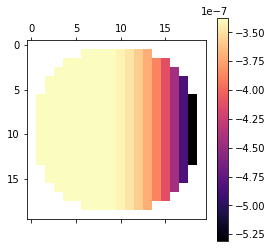

In [28]:
plt.matshow(np.real(TTL_hard),cmap='magma')
plt.colorbar()

In [33]:
print(TTL_simp)
print(np.nanmean(TTL_hard))

-3.414745738786341e-07
(-3.663985e-07+0j)


In [41]:
N=10
t_plot = np.linspace(t_vec[0],t_vec[1],N)
TTL_wf = []
wfe.simple=False
for t in t_vec:
    TTL_wf.append(np.nanmean(wfe.TTL_rec(1,12321,side='l')))

Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture receiving telescope
Type of telescope control is: SS
Simple mode is off, calculating over whole aperture rec

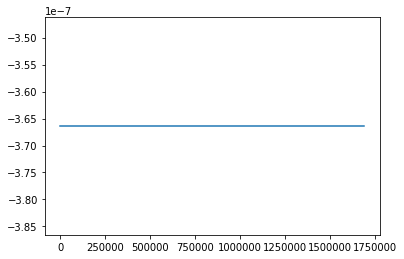

In [43]:
plt.plot(t_vec,TTL_wf)